In [1]:
from pyspark import  SparkContext,SparkConf
sc = SparkContext( )

In [32]:
 #instant: record index
#- dteday : date
#- season : season (1:springer, 2:summer, 3:fall, 4:winter)
#- yr : year (0: 2011, 1:2012)
#- mnth : month ( 1 to 12)
#- hr : hour (0 to 23)
#- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
#- weekday : day of the week
#- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
#+ weathersit : 
#- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
#- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
#- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
#- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
#- hum: Normalized humidity. The values are divided to 100 (max)
#- windspeed: Normalized wind speed. The values are divided to 67 (max)
#- casual: count of casual users
#- registered: count of registered users
#- cnt: count of total rental bikes including both casual and registered-
rawData = sc.textFile('/data/bike-sharing/hour_noheader.csv')
records = rawData.map(lambda x: x.split(','))
print records.take(2)
print rawData.count()

[[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16'], [u'2', u'2011-01-01', u'1', u'0', u'1', u'1', u'0', u'6', u'0', u'1', u'0.22', u'0.2727', u'0.8', u'0', u'8', u'32', u'40']]
17379


In [3]:
records.cache()


PythonRDD[4] at RDD at PythonRDD.scala:48

In [5]:
#首先将第idx列的特征值去重，然后对每个值使用zipWithIndex函数映射到一个唯一的索引，这样就组成了一个RDD的键值映射，键是变量，值是索引。
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()
print get_mapping(records,2)

{u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [38]:
mappings = [get_mapping(records, i) for i in range(2,10)] 
print mappings
#map(len,[i for i in mappings])对列表中的数据，计算和[4, 2, 12, 24, 2, 7, 2, 4]
cat_len = sum(map(len,[i for i in mappings]))  
print cat_len

[{u'1': 0, u'3': 1, u'2': 2, u'4': 3}, {u'1': 0, u'0': 1}, {u'11': 0, u'10': 6, u'12': 7, u'1': 1, u'3': 2, u'2': 8, u'5': 3, u'4': 9, u'7': 4, u'6': 10, u'9': 5, u'8': 11}, {u'20': 2, u'21': 14, u'22': 4, u'23': 15, u'1': 6, u'0': 18, u'3': 7, u'2': 19, u'5': 8, u'4': 20, u'7': 9, u'6': 21, u'9': 10, u'8': 22, u'11': 0, u'10': 12, u'13': 1, u'12': 13, u'15': 11, u'14': 23, u'17': 3, u'16': 17, u'19': 5, u'18': 16}, {u'1': 0, u'0': 1}, {u'1': 0, u'0': 3, u'3': 1, u'2': 4, u'5': 2, u'4': 5, u'6': 6}, {u'1': 0, u'0': 1}, {u'1': 0, u'3': 1, u'2': 2, u'4': 3}]
57
[4, 2, 12, 24, 2, 7, 2, 4]


In [50]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

def extract_features(record): 
    cat_vec = np.zeros(cat_len) 
    #print "recode",record
    step = 0
    for i,raw_feature in enumerate(record[2:9]):
        print i,raw_feature
        dict_code = mappings[i]
        index = dict_code[raw_feature]
        cat_vec[index+step] = 1
        step = step+len(dict_code)
    num_vec = np.array([float(raw_feature) for raw_feature in record[10:14]])
    #将两份特征组合起来
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1])



In [51]:
#point = records.first()
#print extract_label(point),extract_features(point)
data = records.map(lambda point: LabeledPoint(extract_label(point),extract_features(point)))
first_point = data.first()
print first_point


(16.0,[1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0])


In [52]:
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))
data_dt = records.map(lambda point: LabeledPoint(extract_label(point), extract_features_dt(point)))
first_point_dt = data_dt.first()
print '决策树特征向量: '+str(first_point_dt.features)
print '决策树特征向量长度: '+str(len(first_point_dt.features))

决策树特征向量: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
决策树特征向量长度: 12


In [25]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
#训练回归模型
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept =False)
true_vs_predicted = data.map(lambda point:(point.label,linear_model.predict(point.features)))
print '线性回归模型对前5个样本的预测值: '+ str(true_vs_predicted.take(5))

线性回归模型对前5个样本的预测值: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


In [29]:
#训练决策树回归模型
de_model = DecisionTree.trainRegressor(data_dt,{})
preds = de_model.predict(data_dt.map(lambda p: p.features))
real = data_dt.map(lambda p:p.label)
true_vs_predicted_dt = real.zip(preds)
print 'predicted: '+str(true_vs_predicted_dt.take(5)) 
print 'depth: ' + str(de_model.depth()) 
print 'leaves: '+str(de_model.numNodes())

predicted: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
depth: 5
leaves: 63


In [57]:
def squared_error(actual, pred): 
    return (pred-actual)**2 

In [58]:
def abs_error(actual, pred): 
    return np.abs(pred-actual)

In [59]:
def squared_log_error(pred, actual): 
    return (np.log(pred+1)-np.log(actual+1))**2

In [61]:
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean() 
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean() 
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean()) 
print "均方误差：", mse
print "平均绝对误差：", mae
print "均方根对数误差：", rmsle

均方误差： 30679.4538628
平均绝对误差： 130.642876651
均方根对数误差： 1.46533982015


In [62]:
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())
print 'Decision Tree - Mean Squared Error: %2.4f' % mse_dt
print 'Decision Tree - Mean Absolute Error: %2.4f' % mae_dt
print 'Decision Tree - Root Mean Squared Log Error: %2.4f' %rmsle_dt

Decision Tree - Mean Squared Error: 11611.4860
Decision Tree - Mean Absolute Error: 71.1502
Decision Tree - Root Mean Squared Log Error: 0.6251


In [66]:
 %matplotlib inline
import matplotlib
from matplotlib.pyplot import hist
import numpy as np 
import matplotlib.pyplot as plt 
#自行车被租的次数
targets = records.map(lambda r: float(r[-1])).collect() 
hist(targets, bins=40, color='lightblue', normed=True) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6)
plt.show()

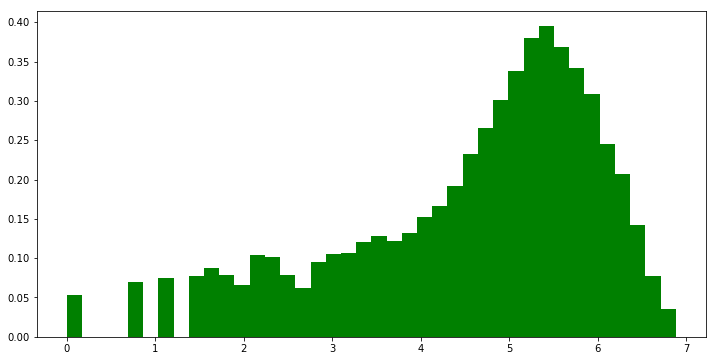

In [70]:
#目标值的对数变换
targets_log = records.map(lambda r:np.log(float(r[-1]))).collect()
hist(targets_log, bins=40, color='green', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,6)
plt.show()

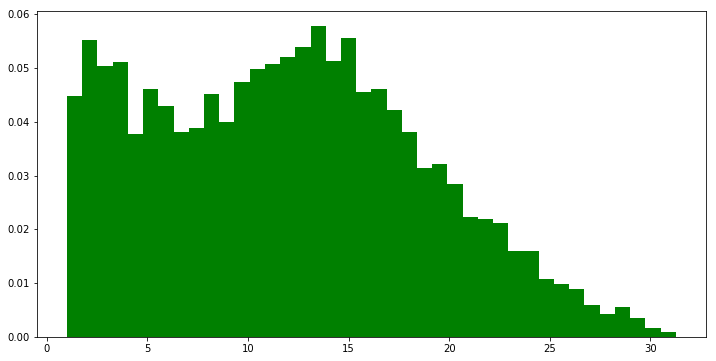

In [71]:
#目标值的平方根变换
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect() 
plt.hist(sqrt_targets, bins=40, color='green', normed=True) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6) 
plt.show()

In [76]:
#变换目标值，确认对模型的影响
data_log = data.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features))
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)
true_vs_predicted_log = data_log.map(lambda p:(np.exp(p.label), np.exp(model_log.predict(p.features))))

#计算模型的MSE,MAE,RMSLE
mse_log = true_vs_predicted_log.map(lambda(t, p): squared_error(t,p)).mean() 
mae_log = true_vs_predicted_log.map(lambda(t, p): abs_error(t, p)).mean() 
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda(t, p): squared_log_error(t, p)).mean())

print'Linear Model —— Mean Squared Error:%2.4f'% mse_log 
print'Linear Model —— Mean Absolue Error:%2.4f'% mae_log 
print'Linear Model —— Root Mean Squared Log Error:%2.4f'% rmsle_log 
print'Linear Model —— Non log-transformed predictions:\n'+ str(true_vs_predicted.take(3))
print'Linear Model —— Log-transformed predictions:\n'+ str(true_vs_predicted_log.take(3))

Linear Model —— Mean Squared Error:50685.5559
Linear Model —— Mean Absolue Error:155.2955
Linear Model —— Root Mean Squared Log Error:1.5411
Linear Model —— Non log-transformed predictions:
[(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Linear Model —— Log-transformed predictions:
[(15.999999999999998, 28.080291845456212), (40.0, 26.959480191001763), (32.0, 26.654725629458021)]


In [77]:
#模型参数调优
train_test_data_split = data.randomSplit([0.8,0.2],123) 
train = train_test_data_split[0] 
test = train_test_data_split[1]
print '测试集的样本数:',test.count()
print '训练集的样本数:',train.count()

测试集的样本数: 3524
训练集的样本数: 13855


In [78]:
train_test_data_split = data_dt.randomSplit([0.8,0.2], 123)
train_dt = train_test_data_split[0]
test_dt = train_test_data_split[1]

In [79]:
#参数调整和评价
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model =LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, 
                                         regType=regType,intercept=intercept)
    testLabel_vs_testPrediction = test.map(lambda point:(point.label, model.predict(point.features)))
    rmsle = np.sqrt(testLabel_vs_testPrediction.map(lambda(t,p):squared_log_error(t,p)).mean())
    return rmsle


In [95]:
#调整迭代次数
params = [1, 5, 10, 20, 50, 100,150]
metrics = [evaluate(train, test, param, 0.01, 0.0, 'l2', False) for param in params]
print params
print metrics

[1, 5, 10, 20, 50, 100, 150]
[2.9352350771042066, 2.0758830668686867, 1.7989931147537059, 1.5883231443924686, 1.4176140084119577, 1.3657070067736425, 1.3602364094306576]


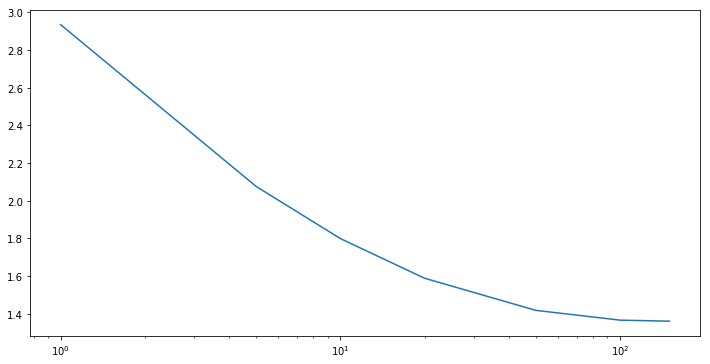

In [96]:
#刚开始，随着迭代次数的正价，损失值越来越小，但到达一定的迭代次数后，效果就不明显了
plt.plot(params, metrics) 
fig = matplotlib.pyplot.gcf() 
fig.set_size_inches(12, 6) 
plt.xscale('log')
plt.show()

In [98]:
#较大的步长，算法收敛太快，可能得到较差的局部最优解
#较小的步长+较大的迭代次数，通常能得到较好的结果
params = [0.01,0.025,  0.05,0.1, 0.25,0.5,1.0]
metrics = [evaluate(train, test, 10, param, 0.0, 'l2', False) for param in params]
print params
print metrics

[0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0]
[1.7989931147537059, 1.4171148324980201, 1.3650071771547911, 1.4304258593507428, 1.452752209079011, 1.397443003471375, nan]


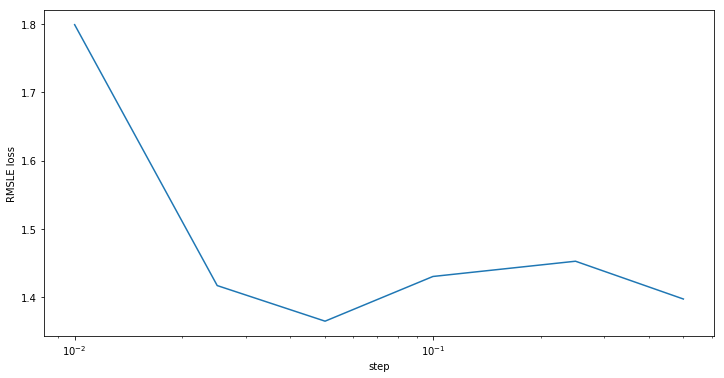

In [99]:
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6)
plt.xscale('log')
plt.xlabel('step')
plt.ylabel('RMSLE loss')


In [107]:
#决策树 训练参数的影响
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth = maxDepth, maxBins = maxBins)
    predictions = model.predict(test.map(lambda point:point.features))
    actual = test.map(lambda point:point.label)
    actual_vs_predictions = actual.zip(predictions)
    rmsle = np.sqrt(actual_vs_predictions.map(lambda(t, p):squared_log_error(t, p)).mean())
    return rmsle

In [109]:
#树的深度影响性能，基本上深度为10最佳
depthParams = [1,2,5,10,15,20]
#print test_dt.take(2)
metrics = [evaluate_dt(train_dt, test_dt, depthParam, 32) for depthParam in depthParams]
print depthParams
print metrics

[1, 2, 5, 10, 15, 20]
[0.98639737057692223, 0.89633757971456884, 0.61770252554657723, 0.40230691776405364, 0.42324548632151338, 0.43101699186923659]


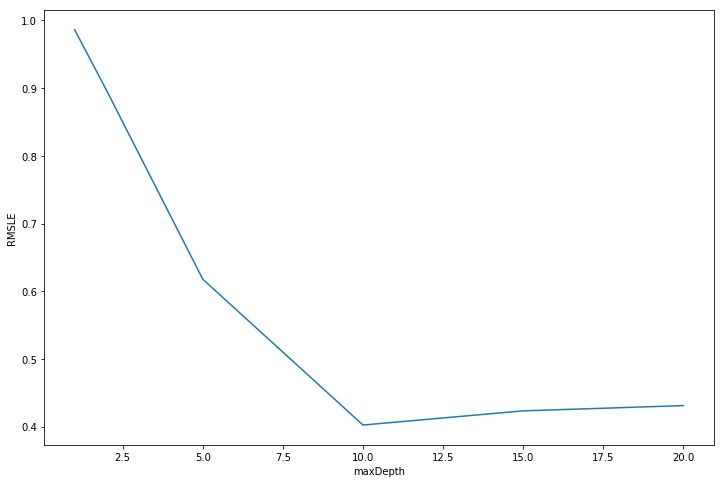

In [110]:
plt.plot(depthParams, metrics)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
plt.xlabel('maxDepth')
plt.ylabel('RMSLE')
plt.show()